# GMV Portfolio with Euro Stoxx 50 constituents

In [1]:
import pandas as pd
import numpy as np
from google.colab import drive
import os
import sys
drive.mount('/content/drive/')
sys.path.insert(0,'/content/drive/MyDrive/BackUp_RL_CodeBase')
os.chdir('/content/drive/MyDrive/BackUp_RL_CodeBase')
os.getcwd()
from scipy.optimize import minimize
from helpers.helperFunction import data_split,splitByRatio

Mounted at /content/drive/


### 1. Functions for use in returns and other computations

In [2]:
### Portfolio Return
def portfolio_return(weights, returns):
    """
    For a period, get starting weights, and security returns for that period
    Compute portfolio return for that period.
    Weights in Nx1 matrix, Returns in Nx1 matrix
    """
    return weights.T @ returns

def portfolio_vol(weights, covmat):
    """
    Computes the vol of a portfolio from a covariance matrix and constituent weights
    Weights are Nx1 matrix and covmat is an NxN matrix
    Covariances and variances are Annualized
    """
    return (weights.T @ covmat @ weights)**0.5

def neg_sharpe_ratio(weights, riskfree_rate, er, cov):
    """
    Compute portfolio returns from weights and expected returns
    Compute portfolio volatility from weights and covariance matrix
    expected returns should be nnnualized
    covariance matrix should be annualized
    Return Sharpe Ratio with a negative sign
    """
    ret = portfolio_return(weights, er)
    vol = portfolio_vol(weights, cov)
    return -(ret-riskfree_rate)/vol
    
def msr(riskfree_rate, er, cov):
    """
    Generate MSR portfolio weights, maximizing sharpe ratio
    Expected returns should be Nx1 matrix, annualized
    Covariance matrix should be NxN matrix, annualized
    Riskfree Rate should be a decimal, annualized rate
    The objective function is to minimize the negative sharpe ratio
    """
    nSec = er.shape[0] # number of tickers/securities in Expected Return
    nCov = cov.shape[0] # number of tickers/securities in Covariance Matrix
    # check if er and cov have same number of securities
    if nSec != nCov:
        raise ValueError("Number of securities should be same in both inputs")
    
    ### we can check if the securities are same, and are in the same order
    
    init_guess = np.repeat(1/nSec, nSec) # initial guess of weights as equal
    bounds = ((0.0, 1.0),)*nSec # an N-tuple of 2-tuples! does not allow negative weight or more than 100%
    weights_sum_to_1 = {'type': 'eq',
                       'fun': lambda weights: np.sum(weights) - 1
                       }
    weights = minimize(neg_sharpe_ratio, init_guess,
                      args=(riskfree_rate, er, cov), method='SLSQP',
                      constraints=(weights_sum_to_1),
                      options={'disp': False},
                      bounds=bounds
                      )
    return weights.x
    
def gmv(cov):
    """
    Returns a weight of global minimum variance portfolio
    Covariance matrix is NxN matrix
    """
    n = cov.shape[0]
    return msr(0, np.repeat(1, n), cov) # Maximize sharpe ratio when all expected returns are equal

def gmv_rolling(dict_cov):
    """
    dict_cov has keys as dates, items as covariance matrix
    returns a dictionary containing the dates and weights
    """
    dict_wt_gmv = {}
    for date_opt, covmat in dict_cov.items():
        dict_wt_gmv[date_opt] = gmv(covmat)
    return dict_wt_gmv

def cov_rolling(rets, lbperiod):
    """
    Given a returns dataframe, and a lookback period in week, month or daily
    for daily, lbperiod should be 252, for weekly 52 and for monthly 12
    Get covariance for each subsequent period ( after one year of observations )
    the function should return annualized covariance matrix
    """
    dict_cov = {}
    nperiods = rets.shape[0]
    for i in range(lbperiod, nperiods):
        cov = rets.iloc[i-lbperiod:i-1].cov() * lbperiod
        date = rets.index[i]
        dict_cov[date] = cov
    return dict_cov

def port_Value(returns, start, period):
    """
    Takes a timeseries of asset returns
    Computes and returns a Dataframe that contains:
    the wealth index
    the previous peaks
    percent drawdowns
    """
    returns = returns.iloc[:,0]
    wealth_index = start*(1+returns).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdowns = (wealth_index - previous_peaks)/previous_peaks
    return pd.DataFrame({
        "Wealth": wealth_index,
        "Peaks": previous_peaks,
        "Drawdown": drawdowns
    }, index=returns.index)

### 2. Read the prices data and clean, organize, make the right frequency

In [3]:
# Read the CSV file into a DataFrame
rawData = pd.read_csv("Input/A_priceRaw.csv")

# Make a pivot table - tickers and closing prices, for each date in the Database
descData = rawData.pivot_table(index='date', columns='tic', values='close')

# Find tickers for which at least 97.5% dates have some price value
nDates = int(descData.shape[0]*0.975)
series_x= descData.describe().transpose()['count']>nDates
remaining_tickers = series_x.index[series_x]

# subset the database with remaining tickers
filtered_DF = descData[remaining_tickers]

# fill where data is unavailable with forward fill
cleaned_DF = filtered_DF.ffill().dropna().copy()
cleaned_DF.index = pd.to_datetime(cleaned_DF.index)


In [4]:
# # Split data, only test period is used. One year look back period, so the test period is shifted with one year.
start = '2002-12-31'
end ='2021-12-31'
cleaned_DF['Date'] = cleaned_DF.index
cleaned_DF = cleaned_DF[(cleaned_DF["Date"] >= start) & (cleaned_DF["Date"] < end)]
cleaned_DF = cleaned_DF.drop(columns='Date')

In [5]:
# Calculate daily returns for the stocks in the database and drop the first row
return_DF_daily = cleaned_DF.pct_change().dropna()

### 3. Process the Returns for Daily Portfolio Management

In [6]:
# Process Daily GMV Portfolios and get a DataFrame with weights
# Use 252 for daily
dict_cov_d = cov_rolling(return_DF_daily, 252)
wt_daily = gmv_rolling(dict_cov_d)
columns = return_DF_daily.columns
df_daily_weights = pd.DataFrame.from_dict(wt_daily, orient='index', columns=columns)

In [7]:
# Get returns DF with same dates as weights DF and compute portfolio returns
rets_daily_Port = return_DF_daily.loc[df_daily_weights.index]

# Calculate portfolio returns for each period and store in a DataFrame
n_Per = rets_daily_Port.shape[0]
dict_PortRet_d = {}
for i in range(n_Per):
    rets = rets_daily_Port.iloc[i]
    weights = df_daily_weights.iloc[i]
    per_Ret = weights@rets
    date = rets_daily_Port.index[i]
    dict_PortRet_d[date] = per_Ret
df_Port_ret_d = pd.DataFrame.from_dict(dict_PortRet_d, orient='index', columns=['Portfolio Return'])

In [8]:
# Take a starting value of portfolio as EUR 1.0 million and compute the progression
start = 1
daily_port_Values = port_Value(df_Port_ret_d, start, 252)

[]

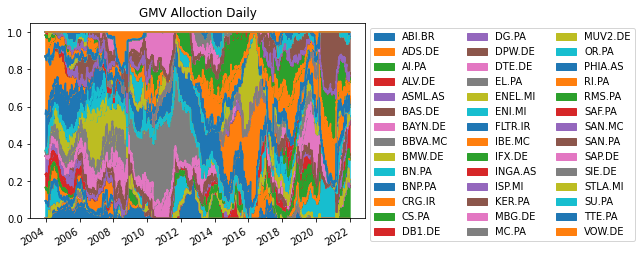

In [9]:
ax_daily_wt = df_daily_weights.plot.area()
ax_daily_wt.set_title("GMV Alloction Daily",color='black')
ax_daily_wt.legend(bbox_to_anchor=(1.0, 1.0),ncol=3)
ax_daily_wt.plot()

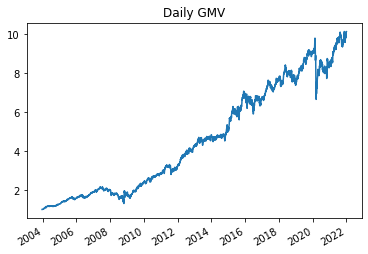

In [10]:
daily_port_Values.Wealth.plot(title='Daily GMV')

In [ ]:
#export
# set date as index: daily_port_Values.to_csv('benchmark_results/GMV.csv',index=True, index_label='date')
# daily_port_Values['Port_Return'] = df_Port_ret_d
# daily_port_Values.to_csv('benchmark_results/GMV.csv',index=True, index_label='date')
# df_daily_weights.to_csv('benchmark_results/wgt_gmv.csv',index=True, index_label='date')


# Section-2: Adding MSR Portfolio

### 1. Get Expected Returns for each time period

In [11]:
# Get daily expected returns
er_DF_daily = (1+return_DF_daily).rolling(window=252).agg(lambda x: x.prod())-1
er_DF_daily = er_DF_daily.dropna()


In [12]:
def msr_rolling(dict_cov, er_DF, riskfree_rate=0.03):
    """
    dict_cov has keys as dates, items as covariance matrix
    er_DF has expected returns for all periods
    returns a dictionary containing the dates and weights
    """
    dict_wt_msr = {}
    for date_opt, covmat in dict_cov.items():
        er = er_DF.loc[date_opt]
        dict_wt_msr[date_opt] = msr(riskfree_rate, er, covmat)
    return dict_wt_msr

### 4. Daily MSR portfolio

In [ ]:
# Process Daily MSR Portfolios and get a DataFrame with weights
# Use 252 for daily
er_DF_d_sh = er_DF_daily.loc[dict_cov_d.keys()]
wt_daily_msr = msr_rolling(dict_cov_d, er_DF_d_sh, 0.03)
columns = return_DF_daily.columns
df_daily_weights_msr = pd.DataFrame.from_dict(wt_daily_msr, orient='index', columns=columns)

In [ ]:
# Get returns DF with same dates as weights DF and compute portfolio returns
rets_daily_Port_msr = return_DF_daily.loc[df_daily_weights_msr.index]

# Calculate portfolio returns for each period and store in a DataFrame
n_Per = rets_daily_Port_msr.shape[0]
dict_PortRet_d_msr = {}
for i in range(n_Per):
    rets = rets_daily_Port_msr.iloc[i]
    weights = df_daily_weights_msr.iloc[i]
    per_Ret = weights@rets
    date = rets_daily_Port_msr.index[i]
    dict_PortRet_d_msr[date] = per_Ret
df_Port_ret_d_msr = pd.DataFrame.from_dict(dict_PortRet_d_msr, orient='index', columns=['Portfolio Return'])

In [ ]:
# Take a starting value of portfolio as EUR 1.0 million and compute the progression
start = 1
daily_port_Values_msr = port_Value(df_Port_ret_d_msr, start, 252)

In [ ]:
# ax_daily_wt_msr = rets_daily_Port_msr.plot.area()
# ax_daily_wt_msr.set_title("MSR Alloction Daily",color='black')
# ax_daily_wt_msr.legend(bbox_to_anchor=(1.0, 1.0),ncol=3)
# ax_daily_wt_msr.plot()

In [ ]:
# #export
# set date as index: daily_port_Values_msr.to_csv('benchmark_results/MSR.csv',index_col='date')
# daily_port_Values_msr['Port_Return'] = df_Port_ret_d_msr
# daily_port_Values_msr.to_csv('benchmark_results/MSR.csv',index=True, index_label='date')
# df_daily_weights_msr.to_csv('benchmark_results/wgt_msr.csv',index=True, index_label='date')